In [ ]:
import rospy

In [ ]:
DEFAULT_I = 10
try:
    i = rospy.get_param('ii')
except:
    print('can not collect param. Going to use default value.')
    i = DEFAULT_I
    
print(i)

In [1]:
from pcg_gazebo.task_manager import ProcessManager
from pcg_gazebo.generators.creators import create_models_from_config

TARGET_SIM = dict(
    ros_host='localhost',
    ros_port=11311,
    gazebo_host='localhost',
    gazebo_port=11345
)

process_manager = ProcessManager(**TARGET_SIM)
gazebo_proxy = process_manager.get_gazebo_proxy()
print(gazebo_proxy.ros_config)

ROS_MASTER_URI=http://localhost:11311, GAZEBO_MASTER_URI=http://localhost:11345


In [65]:
## spawn box to the any place of wall collision space coordinates

import numpy as np
from pcg_gazebo.generators.shapes import random_rectangle, \
    random_points_to_triangulation, random_rectangles
import trimesh

THRESHOLD_WALL = 0.7
ROOM_SIZE_RADIUS = 4.5
ROOM_WALL_HEIGHT = 0.8
OBSTACLE_NUM = 10
OBSTACLE_SIZE = 0.8
TARGET_SIZE = 0.2
AGENT_SIZE = 0.3

config = [
    dict(
        type='extrude',
        args=dict(
            polygon=random_points_to_triangulation(
                x_min=-ROOM_SIZE_RADIUS,
                x_max=ROOM_SIZE_RADIUS,
                y_min=-ROOM_SIZE_RADIUS,
                y_max=ROOM_SIZE_RADIUS
            ),
            height=ROOM_WALL_HEIGHT,
            thickness=0.05,
            extrude_boundaries=True,
            name='extruded_poly_triangulation',
            color='random'
        )
    )
]

models = create_models_from_config(config)

for model in models:
    print(model.get_link_by_name('visual_mesh'))
    print(model.links is None)
    for elem in model.links:
        cols = model.get_link_by_name(elem).collisions
        print(cols[0])
        col_mesh = cols[0]._geometry._geometry_entity.get_meshes()[0]
        sample_pts = cols[0]._geometry._geometry_entity.get_samples(OBSTACLE_NUM)
        print(sample_pts)
    model.spawn(
        gazebo_proxy=gazebo_proxy, 
        robot_namespace=model.name,
        pos=[0,0,ROOM_WALL_HEIGHT/2]
    )

mini_col_mesh = trimesh.Trimesh(np.array(col_mesh.vertices)*THRESHOLD_WALL)

sample_pts = np.array(mini_col_mesh.convex_hull.sample(len(sample_pts)))
sample_pts += cols[0].pose.position * THRESHOLD_WALL
sample_pts[:,2] = OBSTACLE_SIZE/2

sample_rot = np.zeros_like(sample_pts)
sample_rot[:,2] = np.random.random([len(sample_pts)])*np.pi*2

sizes = [[OBSTACLE_SIZE, OBSTACLE_SIZE, OBSTACLE_SIZE]]*len(sample_pts)

config_obstacle_box = [
    dict(
        type='box_factory',
        args=dict(
            size=sizes,
            name='obstacle_box',
            use_permutation=True,
            color='white'
        )
    )
]

models_box = create_models_from_config(config_obstacle_box)
for model, p, r in zip(models_box, sample_pts, sample_rot):
    print(p, r)
    model.spawn(
        gazebo_proxy=gazebo_proxy, 
        robot_namespace=model.name,
        pos=list(p),
        rot=list(r)
    )

None
False
<collision name="collision">
  <geometry>
    <mesh>
      <scale>1 1 1</scale>
      <uri>file:///root/.pcg/meshes/PdCmeuOXXG.stl</uri>
    </mesh>
  </geometry>
  <max_contacts>20</max_contacts>
  <pose frame="">-0.0891299 0.428434 -0.4 0 -0 0</pose>
</collision>

[[-2.89342093 -1.78297427  0.        ]
 [ 2.5713203  -1.13323296  0.45532893]
 [ 2.56141512  2.93129012  0.76892954]
 [-1.31444832 -3.39666908  0.25542688]
 [-1.33372228  3.26017729  0.26264667]
 [-1.1043176  -3.56328975  0.        ]
 [ 4.17133736  2.64854972  0.17280899]
 [-3.68370323  3.29799138  0.58853169]
 [ 1.34125528 -2.74121799  0.43444478]
 [-3.9682393   0.0549935   0.79966758]]
(array([ 1.62344561, -0.15571202,  0.4       ]), array([0.        , 0.        , 4.16985031]))
(array([-1.88265641,  1.62610608,  0.4       ]), array([0.        , 0.        , 4.47324931]))
(array([ 0.45986315, -0.16154895,  0.4       ]), array([0.        , 0.        , 4.95961693]))
(array([0.02115466, 1.0401415 , 0.4       ]), arr

In [66]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=np.sqrt((OBSTACLE_SIZE**2)*2), min_samples=1).fit(np.array(sample_pts))
labels = db.labels_
print(labels)


[0 1 2 3 4 5 4 0 6 4]


In [67]:
sizes = [[TARGET_SIZE, TARGET_SIZE, TARGET_SIZE]]*(max(labels)+1)
config_target_box = [
    dict(
        type='box_factory',
        args=dict(
            size=sizes,
            name='target_box',
            use_permutation=True,
            color='cyan'
        )
    )
]

models_target = create_models_from_config(config_target_box)

In [68]:
import quaternion

def get_square_horizon(base_pos, radius, z_angle=0):
    d1 = [1,1,-1,-1]
    d2 = [1,-1,-1,1]
    poss = np.array([np.quaternion(1,d1[i]*radius,d2[i]*radius,0) for i in range(4)])
    q = quaternion.from_euler_angles(0,0,z_angle)
    pq = q*poss*q.conj()
    
    return np.array([[p.x, p.y, p.z] for p in pq])+base_pos

def get_extended_face(face_vertices, length):
    face_bottom = np.copy(face_vertices)
    face_bottom[:,2] += length
    return np.concatenate([face_vertices, face_bottom])

# p = [0, 0, 0]
# ang = np.pi/4
# print(get_square_horizon(p, 0.1, ang))

In [69]:
from shapely.geometry.polygon import Polygon

zone_base_2d = [None]*(max(labels)+1)
for i in range(len(zone_base_2d)):
    pts = sample_pts[labels==i]
    if len(pts) > 2:
        zone_base_2d[i] = trimesh.convex.hull_points(pts[:,:2])
    else:
        zone_base_2d[i] = pts

zone_vertices_2d = [None]*len(zone_base_2d)

for i in range(len(zone_base_2d)):
    pts = sample_pts[labels==i]
    rts = sample_rot[labels==i]
    vertices = np.concatenate(
        [get_square_horizon(p, np.sqrt((OBSTACLE_SIZE**2)*2)/2, r[2]) for p,r in zip(pts,rts)]
    )
    zone_vertices_2d[i] = trimesh.convex.hull_points(vertices[:,:2])
    
zone_hull = [None]*len(zone_base_2d)
for i in range(len(zone_base_2d)):
    p3 = np.zeros([len(zone_vertices_2d[i]),3])
    p3[:,:2] = zone_vertices_2d[i]
    zone_hull[i] = trimesh.Trimesh(vertices=get_extended_face(p3, OBSTACLE_SIZE)).convex_hull


# hull_points_2d = [None]*(max(labels)+1)
# for i in range(len(hull_points_2d)):
#     pts = sample_pts[labels==i]
#     if len(pts) < 3:
#         v = []
#         for p in pts:
#             v.extend(get_square_horizon(p, 0.05))
#         pts = np.array(v)
        
# #     convex_2d = ConvexHull(pts[:,:2])
#     hull_points_2d[i] = trimesh.convex.hull_points(pts[:,:2])


# zone_hull = [None]*(len(hull_points_2d)) # trimesh.Trimesh in
# for i in range(len(zone_hull)):
#     tmp = np.zeros([len(hull_points_2d[i]), 3])
#     tmp[:,:2] = hull_points_2d[i]
#     pts = get_extended_face(tmp, OBSTACLE_SIZE)
#     zone_hull[i] = trimesh.Trimesh(vertices=pts).convex_hull
    
    
# zone_hull_expand = [None]*(len(hull_points_2d)) # trimesh.Trimesh in
# zone_vecs_g2v = [None]*(len(hull_points_2d)) # normalized vector centroid to vertice
# hull_points_2d_expand = [None]*(len(hull_points_2d))
# for i in range(len(zone_hull_expand)):
#     g = np.mean(hull_points_2d[i], axis=0)
    
# #     g = Polygon(hull_points_2d[i]).convex_hull.centroid.coords[0]

#     vec_g2v = hull_points_2d[i]-g
#     norm = np.linalg.norm(vec_g2v, axis=1, ord=2)
#     zone_vecs_g2v[i] = vec_g2v / (np.array([norm]).T) ## KETAOTI OKIRUYO
#     hull_points_2d_expand[i] = hull_points_2d[i]+zone_vecs_g2v[i]*(np.sqrt((OBSTACLE_SIZE**2)*2)/2)
    
#     tmp = np.zeros([len(hull_points_2d[i]), 3])
#     tmp[:,:2] = hull_points_2d_expand[i]
#     pts = get_extended_face(tmp, OBSTACLE_SIZE)
#     zone_hull_expand[i] = trimesh.Trimesh(vertices=pts).convex_hull
    
# print("zone_vecs_g2v", zone_vecs_g2v)
# print("zone_full: \n{}".format(zone_hull[0].mass))
# print("zone_full_expand: \n{}".format(zone_hull_expand[0].mass))


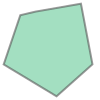

In [70]:
Polygon(zone_vertices_2d[0])

### Methods to generate position of target

Target position is sampled from convex face formed by cluster.

In [71]:
zone_samples = [None]*len(zone_hull)
for i in range(len(zone_samples)):
    ## sample_surface return tuple, so choice 0 index
    samples = trimesh.sample.sample_surface_even(zone_hull[i], 100)[0]
    zone_samples[i] = samples[
        np.logical_and(
            np.not_equal(samples[:,2], 0), 
            np.not_equal(samples[:,2], OBSTACLE_SIZE)
        )
    ]

choiced_goal = np.zeros([len(zone_hull),3])
for i in range(len(choiced_goal)):
    choiced_goal[i] = zone_samples[i][np.random.choice(range(len(zone_samples[i])))]
    
choiced_goal[:,2] = TARGET_SIZE/2

print(choiced_goal)
for model, p in zip(models_target, choiced_goal):
    model.get_link_by_name('link').disable_collision()
    model.spawn(
        gazebo_proxy=gazebo_proxy, 
        robot_namespace=model.name,
        pos=list(p)
    )

[[ 1.00900526  0.13199453  0.1       ]
 [-1.72201765  2.16919671  0.1       ]
 [ 0.08372353  0.32694145  0.1       ]
 [-0.55432778  1.01262757  0.1       ]
 [-0.58385147  1.36911871  0.1       ]
 [-0.90354071 -0.23338709  0.1       ]
 [ 0.46640214 -1.68223523  0.1       ]]


In [42]:
def delete_models(model_name, start=None, stop=None):
    if start is not None and stop is not None:
        for i in range(start, stop+1):
            gazebo_proxy.delete_model(model_name=model_name+"_"+str(i))
    else:
        gazebo_proxy.delete_model(model_name=model_name)
        
delete_models('target_box', 3, 4)